In this project, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.  

##Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this project, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17473536/17464789 [==============================] - 0s 0us/step


Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 

**[TO COMPLETE]** In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in `model.compile()` and motivate your choice.


Please, insert your answer in this text cell.

**Answer:** [TO COMPLETE]

The choice of the activation function is dependent on the type of problem that is being solved; regression or classification.

Here, the probelm is a binary classification problem that requires the prediction of the sentiment of the reviews. The sentiment can be either negative or positive (0 or 1), i.e. the outcomes of the model (classes) are mutually exclusive. Therefore, for a binary classification problem the approproate output activation function to use is the sigmoid function because the sigmoid activation function can take any real value as input and gives values in the range of 0 to 1 as outputs. 

The more positive (larger) the input value is, the closer it will be to 1, and vice versa for negative values.

For loss function: objective is to minimize the loss function. And we do this by penalising the probabilities that are predicted by the model based on how far or close it is to the actual value. Since this is a binary classification problem, the most appropriate loss function to use is the binary crossentropy. It calculates the negative average of the log of the corrected predicted probabilities. 

Categorical cross-entropy and sparse categorical cross-entropy is not used here because these loss funcions are used when the data is hot encoded and the truth labels are integer encoded, respectively.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Now we have to train the model:

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 95s 464ms/step - loss: 0.6662 - accuracy: 0.5846 - val_loss: 0.5003 - val_accuracy: 0.7698
Epoch 2/10
196/196 [==============================] - 88s 446ms/step - loss: 0.4270 - accuracy: 0.8120 - val_loss: 0.4011 - val_accuracy: 0.8286
Epoch 3/10
196/196 [==============================] - 87s 446ms/step - loss: 0.3045 - accuracy: 0.8785 - val_loss: 0.3636 - val_accuracy: 0.8487
Epoch 4/10
196/196 [==============================] - 86s 440ms/step - loss: 0.2374 - accuracy: 0.9071 - val_loss: 0.3715 - val_accuracy: 0.8442
Epoch 5/10
196/196 [==============================] - 86s 438ms/step - loss: 0.1738 - accuracy: 0.9375 - val_loss: 0.4204 - val_accuracy: 0.8135
Epoch 6/10
196/196 [==============================] - 87s 443ms/step - loss: 0.1396 - accuracy: 0.9508 - val_loss: 0.4083 - val_accuracy: 0.8509
Epoch 7/10
196/196 [==============================] - 85s 433ms/step - loss: 0.1012 - accuracy: 0.9676 - val_loss: 0.4452 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 14s - loss: 0.5838 - accuracy: 0.8433 - 14s/epoch - 35ms/step
accuracy: 84.33%


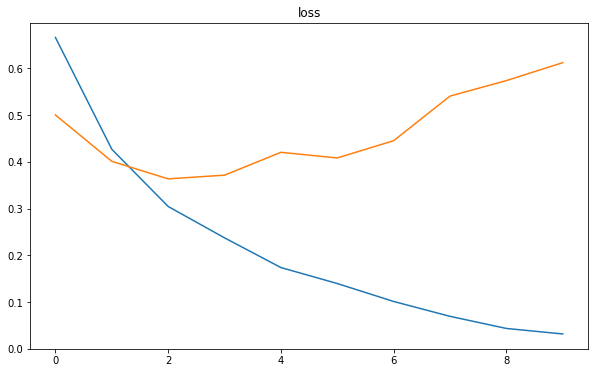

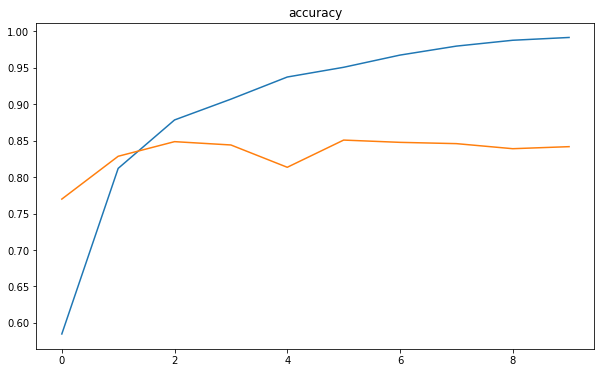

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**Answer:** The LSTM model had an accuracy of 86.05% while the GRU model had an accuracy of 85.47%. The time it took to train both the models was very similar, with 4s/epoch for the LSTM model and 3s/epoch for the GRU model. The total number of parameters were 105,537 and 104,257 for the LSTM and GRU model, respectively. 

It can be noted that the LSTM model has a slightly higher accuracy than the GRU model but it also took slighly more time to train the model as well - which is most likely due to it also having slightly more total parameters than the GRU model.

In both of the model there are clear signs of overfitting, where the training accuracy is much more than the validation accuracy. For both models, the validation accuracy somewhat remained stable after 1 epoch or so but the training accuracy kept increasing. The validation loss can also be observed to be increasing for the both the models after only initially slightly decreasing. However, both models have slightly less overfitting than the simpleRNN model. Overfitting is normal in NLP projects because no matter how many words we have in our training set word bank, validation data most likelu might still have new words in it and therefore will result in a poorer performance on the validation set. 

Overall, both of these models performed better than the simple RNN's 84.94% model accuracy and performed significanctly better in terms of algorithm training time.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 10)          100000    
                                                                 
 lstm (LSTM)                 (None, 16)                1728      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 101,745
Trainable params: 101,745
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 8s 23ms/step - loss: 0.5557 - accuracy: 0.7222 - val_loss: 0.3817 - val_accuracy: 0.8361
Epoch 2/10
196/196 [==============================] - 4s 21ms/step - loss: 0.3542 - accuracy: 0.8545 - val_loss: 0.4547 - val_accuracy: 0.8041
Epoch 3/10
196/196 [======

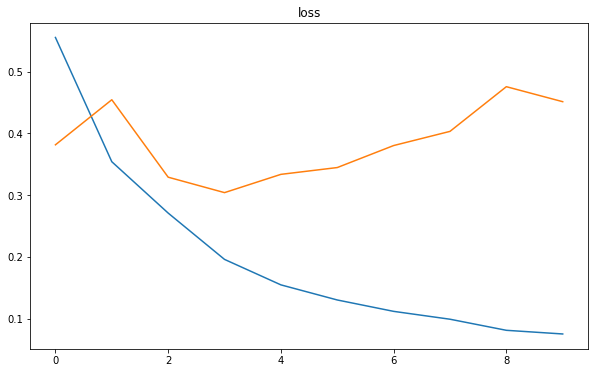

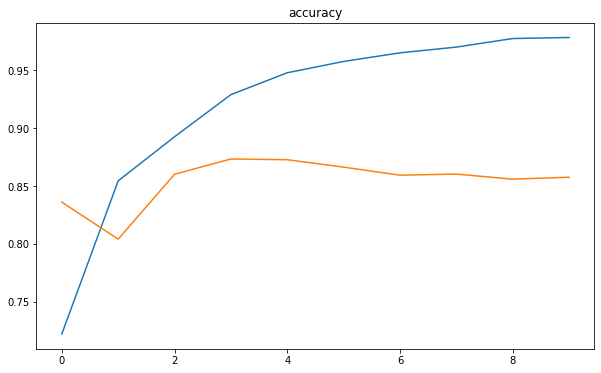

In [ ]:
# LSTM - complete with model definition, summary, fit and plots.

model2 = keras.models.Sequential()
model2.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model2.add(keras.layers.LSTM(16))
model2.add(keras.layers.Dense(1, activation = 'sigmoid'))

model2.compile(loss = 'binary_crossentropy', optimizer="adam", metrics=["accuracy"])


model2.summary()


history2 = model2.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))


plot_loss(history2)

plot_accuracy(history2)

scores2 = model2.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model2.metrics_names[1], scores2[1]*100))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 10)          100000    
                                                                 
 gru (GRU)                   (None, 16)                1344      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 6s 24ms/step - loss: 0.5593 - accuracy: 0.6868 - val_loss: 0.3673 - val_accuracy: 0.8435
Epoch 2/10
196/196 [==============================] - 4s 21ms/step - loss: 0.2898 - accuracy: 0.8844 - val_loss: 0.3273 - val_accuracy: 0.8638
Epoch 3/10
196/196 [======

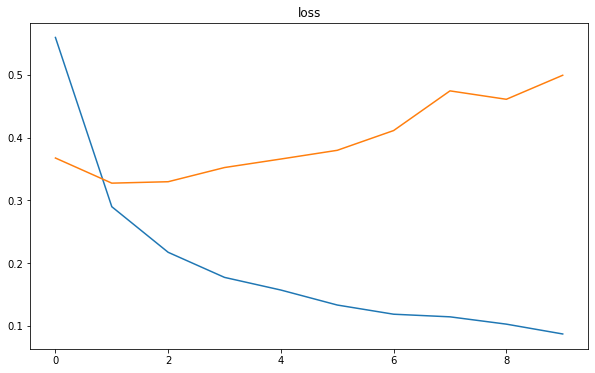

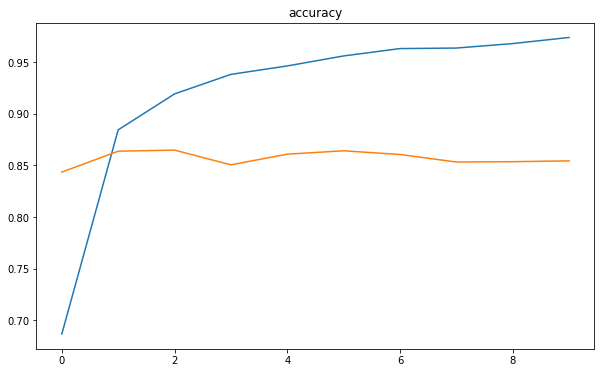

In [ ]:
# GRU - complete with model definition, summary, fit and plots.

model3 = keras.models.Sequential()
model3.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model3.add(keras.layers.GRU(16))
model3.add(keras.layers.Dense(1, activation = 'sigmoid'))

model3.compile(loss = 'binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model3.summary()


history3 = model3.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))


plot_loss(history3)

plot_accuracy(history3)

scores3 = model3.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model3.metrics_names[1], scores3[1]*100))

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use?

**Insert cells (code and text) with results and discussion immediately after this cell** 



**Answer**: The simpleRNN model has 101,409 total parameters on 32 units. While the LSTM and GRU models have 105,537 and 104,257 total parameters respectively, on 32 units. To have a fairer comparison, a few trials were carried out to find how many units would need to be used for each model to have somehwat the same number of total parameters.

With 16 units, the LSTM model has 101,745 total parameters while the GRU model with 16 units has 101,361 total parameters - which are both very close to the number of parameters the simpleRNN model has with 32 units (101,409 total parameters). Therefore, to perform a fair comparison the SimpleRNN model should have 32 units while the LSTM and GRU models should have 16 units each.

It can be noted that the accuracies of both the LSTM model and the GRU model decreased when the number of units were decreased from 32 to 16, albiet, not significantly. Although, Model training times remained the same.

### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 10)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 11s 43ms/step - loss: 0.6565 - accuracy: 0.6578 - val_loss: 0.6116 - val_accuracy: 0.7567
Epoch 2/5
196/196 [==============================] - 8s 39ms/step - loss: 0.4281 - accuracy: 0.8265 - v

391/391 - 5s - loss: 0.3684 - accuracy: 0.8427 - 5s/epoch - 13ms/step
accuracy: 84.27%


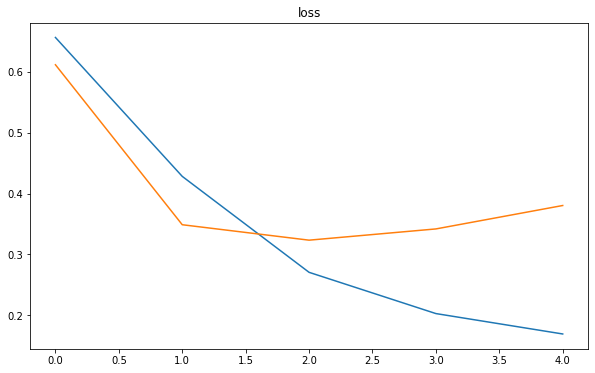

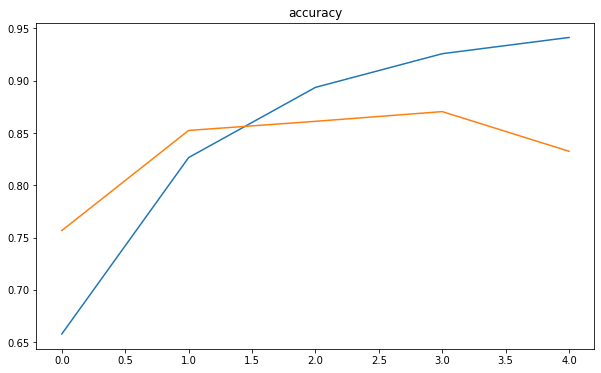

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.3: Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. To define the Transformer we will define a class that inherits from [tensorflow.keras.layers.Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). This class represents a layer, that is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), both defined in the constructor. In the following cell, we will override these two methods in order to define the TransformerLayer. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer, defined using the [tensorflow.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
*   Dropout operation (*dropout_att*)
*   Layer Normalization (*layernorm_att*)
*   A feedforward Neural Network, defenid by using keras.Sequential, and Dense layer
*   Dropout operation (*dropout_fnn*)
*   Layer Normalization (*layernorm_fnn*) that has in input the summation of the attention layer output and the feedforward NN output



In [ ]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [ ]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.


**[TO COMPLETE]** Experiment with the `embed_dim, num_heads, ff_dim` and discuss the influence of these parameters in the obtained results, considering the accuracy of the output at the time required to perform the training phase. Report the discussion in the cell at the end of the notebook.

In [ ]:
embed_dim = 8  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid)
)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/5
196/196 [==============================] - 8s 34ms/step - loss: 0.4864 - accuracy: 0.7548 - val_loss: 0.3522 - val_accuracy: 0.8479
Epoch 2/5
196/196 [==============================] - 7s 33ms/step - loss: 0.2464 - accuracy: 0.9056 - val_loss: 0.3252 - val_accuracy: 0.8647
Epoch 3/5
196/196 [==============================] - 7s 33ms/step - loss: 0.1939 - accuracy: 0.9302 - val_loss: 0.3867 - val_accuracy: 0.8516
Epoch 4/5
196/196 [==============================] - 6s 33ms/step - loss: 0.1709 - accuracy: 0.9392 - val_loss: 0.3628 - val_accuracy: 0.8525
Epoch 5/5
196/196 [==============================] - 6s 33ms/step - loss: 0.1395 - accuracy: 0.9530 - val_loss: 0.3840 - val_accuracy: 0.8607
391/391 - 2s - loss: 0.3785 - accuracy: 0.8610 - 2s/epoch - 5ms/step
accuracy: 86.10%


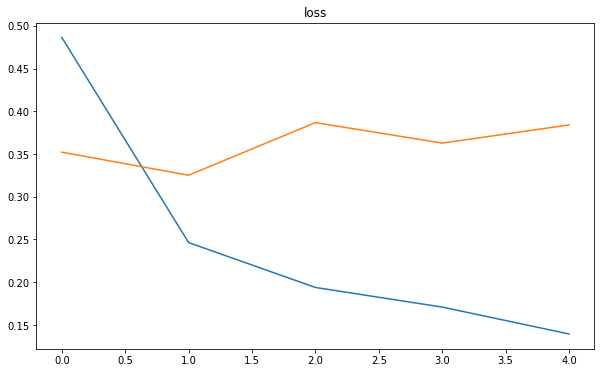

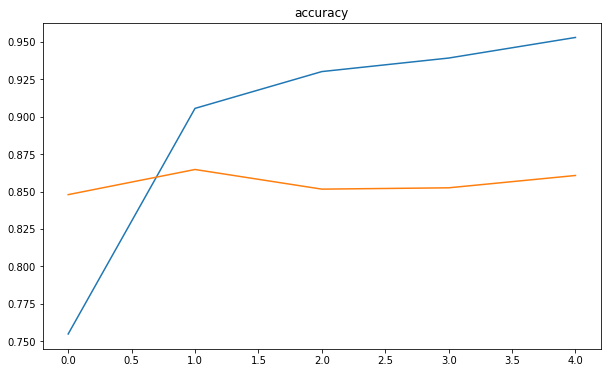

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

**Insert the discussion here**: [TO COMPLETE]

Embedded Dimension size: Increasing the embedding size of each token increases the time it takes to train the model. It doesnt have much of a difference on the accuracy but seem to negatively affect the loss. Loss seems to increase with increased embedded dimension size.
- 8: loss: 0.4034 - accuracy: 0.8576 - time: 1s/epoch
- 16: loss: 0.3967 - accuracy: 0.8591 - time: 1s/epoch
- 32: loss: 0.4081 - accuracy: 0.8390 - time: 1s/epoch
- 64: loss: 0.4456 - accuracy: 0.8507 - time: 1s/epoch
- 128: loss: 0.4341 - accuracy: 0.8489 - time: 2s/epoch
- 256: loss: 0.4302 - accuracy: 0.8523 - time: 3s/epoch



Number of Attention heads: Increasing the number of attention heads does increase n the model accuracy however, it also increases the time taken to train the model. It can also be noted that increasing the number of attention heads does reduce the loss as well.
- 1: loss: 0.4770 - accuracy: 0.8220 - time: 1s/epoch
- 2: loss: 0.4461 - accuracy: 0.8374 - time: 1s/epoch
- 4: loss: 0.4291 - accuracy: 0.8520 - time: 2s/epoch
- 6: loss: 0.4208 - accuracy: 0.8524 - time: 2s/epoch
- 8: loss: 0.3661 - accuracy: 0.8591 - time: 2s/epoch
- 10: loss: 0.3943 - accuracy: 0.8544 - time: 2s/epoch


ff_dim: Increasing Hidden layer size in feed forward network inside transformer marginally increases the model accuracy and decreases the loss. However, it does seem to have much of an effect on the time taken to train the model.
- 16: loss: 0.4689 - accuracy: 0.8443 - time: 1s/epoch
- 32: loss: 0.4677 - accuracy: 0.8306 - time: 1s/epoch
- 64: loss: 0.3994 - accuracy: 0.8506 - time: 1s/epoch
- 128: loss: 0.4134 - accuracy: 0.8575 - time: 1s/epoch
- 256: loss: 0.4146 - accuracy: 0.8584 - time: 1s/epoch

After experimenting with the different parameters, the combination of parameters that yields the best results is:
- embed_dim = 8  
- num_heads = 8  
- ff_dim = 256

These parameters produce the following results: 
loss: 0.3785 - accuracy: 0.8610 - time: 2s/epoch

